In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time
from keras.backend import tensorflow_backend as K
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.0.0


In [3]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [4]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [5]:
type(train_data)

numpy.ndarray

In [6]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [17]:
test_data[0]

array([   1,  591,  202,   14,   31,    6,  717,   10,   10,    2,    2,
          5,    4,  360,    7,    4,  177, 5760,  394,  354,    4,  123,
          9, 1035, 1035, 1035,   10,   10,   13,   92,  124,   89,  488,
       7944,  100,   28, 1668,   14,   31,   23,   27, 7479,   29,  220,
        468,    8,  124,   14,  286,  170,    8,  157,   46,    5,   27,
        239,   16,  179,    2,   38,   32,   25, 7944,  451,  202,   14,
          6,  717,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [5]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [6]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [8]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [13]:
start_time=time.time()
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
print('Training took {} seconds'.format(time.time()-start_time))

Train on 15000 samples, validate on 10000 samples
Epoch 1/50
15000/15000 [==============================] - 1s 78us/sample - loss: 0.3870 - acc: 0.8749 - val_loss: 0.4042 - val_acc: 0.8544
Epoch 2/50
15000/15000 [==============================] - 1s 78us/sample - loss: 0.3579 - acc: 0.8843 - val_loss: 0.3818 - val_acc: 0.8592
Epoch 3/50
15000/15000 [==============================] - 1s 78us/sample - loss: 0.3332 - acc: 0.8903 - val_loss: 0.3646 - val_acc: 0.8630
Epoch 4/50
15000/15000 [==============================] - 1s 78us/sample - loss: 0.3123 - acc: 0.8942 - val_loss: 0.3496 - val_acc: 0.8672
Epoch 5/50
15000/15000 [==============================] - 1s 78us/sample - loss: 0.2933 - acc: 0.9001 - val_loss: 0.3370 - val_acc: 0.8714
Epoch 6/50
15000/15000 [==============================] - 1s 84us/sample - loss: 0.2775 - acc: 0.9055 - val_loss: 0.3272 - val_acc: 0.8750
Epoch 7/50
15000/15000 [==============================] - 1s 77us/sample - loss: 0.2627 - acc: 0.9106 - val_loss: 0.

In [9]:
# model.save("model.h5")
model = tf.keras.models.load_model("model.h5")

In [10]:
results = model.evaluate(test_data, test_labels)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

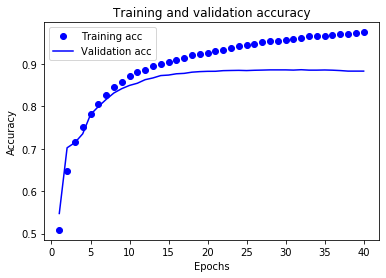

In [22]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
test_labels[:5]

array([0, 1, 1, 0, 1], dtype=int64)

In [19]:
test_data

array([[   1,  591,  202, ...,    0,    0,    0],
       [   6,  176,    7, ...,  125,    4, 3077],
       [  57, 4893,    5, ...,    9,   57,  975],
       ...,
       [   1,   13, 1408, ...,    0,    0,    0],
       [   1,   11,  119, ...,    0,    0,    0],
       [   1,    6,   52, ...,    0,    0,    0]])

In [30]:
print(type(test_data))
for i in test_data[:3]:
    print(type(i))
print()
print(test_data.shape)
for i in test_data[:3]:
    print(i.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

(25000, 256)
(256,)
(256,)
(256,)


In [22]:
results = model.predict(test_data[:10])

In [26]:
test_data.shape

(25000, 256)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
results

array([[0.03301674],
       [0.99991   ],
       [0.6138225 ],
       [0.847412  ],
       [0.9985951 ],
       [0.98039013],
       [0.9422918 ],
       [0.00419185],
       [0.97596675],
       [0.999977  ]], dtype=float32)

In [33]:
test = "pagal"
test = test.lower().split(" ")
data = []
for i in range(len(test)):
    t = word_index[test[i]]
    data.append(t)
length = len(test) 
while length<256:
    data.append(0)
    length+=1
data = np.array(data)
data = data.reshape(1,256)

In [35]:
data

array([[56990,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [34]:
model.predict(data)

InvalidArgumentError:  indices[0,0] = 56990 is not in [0, 10000)
	 [[node sequential/embedding/embedding_lookup (defined at C:\Users\admin\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_distributed_function_3638]

Function call stack:
distributed_function


In [39]:
test

['the', 'movie', 'is', 'bad']

In [40]:
word_index["bad"]

78

In [41]:
test_data

array([[   1,  591,  202, ...,    0,    0,    0],
       [   6,  176,    7, ...,  125,    4, 3077],
       [  57, 4893,    5, ...,    9,   57,  975],
       ...,
       [   1,   13, 1408, ...,    0,    0,    0],
       [   1,   11,  119, ...,    0,    0,    0],
       [   1,    6,   52, ...,    0,    0,    0]])

In [4]:

config = tf.config(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, \
                        allow_soft_placement=True, device_count = {'CPU': 1})
session = tf.Session(config=config)
K.set_session(session)

TypeError: 'module' object is not callable

In [5]:
tf.test.is_gpu_available()

False

In [28]:
tf.config.threading.set_inter_op_parallelism_threads(4)

In [27]:
tf.config.threading.set_intra_op_parallelism_threads(4)

RuntimeError: Intra op parallelism cannot be modified after initialization.